In [1]:
import numpy as np
import torch
import os, sys

In [2]:
project_root = os.path.abspath("..")
src_root = os.path.join(project_root, "src")

sys.path = [p for p in sys.path if p not in (project_root, src_root)]

sys.path.insert(0, project_root)
sys.path.insert(1, src_root)


if "src" in sys.modules:
    del sys.modules["src"]

import src

In [3]:
from src.utils import set_seed, get_device
from src.data import load_har, make_train_val_test, make_dataloaders
from src.models import LRBaseline, SmallCNN
from src.train import train_classifier, evaluate_classifier

In [4]:
from src.features import FeatureStats
from src.clip import clip_quantile_box, l2_group_clip, meb_clip
from src.clip import estimate_l2_radius, estimate_meb_params

stats = FeatureStats.load("../notebooks/feature_stats.npz")

In [5]:
X_train = np.loadtxt("../data/UCI_HAR_Dataset/train/X_train.txt")
y_train = np.loadtxt("../data/UCI_HAR_Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("../data/UCI_HAR_Dataset/test/X_test.txt")
y_test = np.loadtxt("../data/UCI_HAR_Dataset/test/y_test.txt").astype(int)

In [6]:
class HARDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        # Ensure shape is (N, 1, D)
        if self.X.ndim == 2:
            self.X = self.X.unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HARDataset(X_train, y_train)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
)

In [7]:
from torch.utils.data import DataLoader

train_dataset = HARDataset(X_train, y_train)
test_dataset = HARDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
)

print("train_loader batches:", len(train_loader))
print("test_loader batches:", len(test_loader))


train_loader batches: 58
test_loader batches: 24


In [8]:
from src.features import compute_feature_stats_from_loader

stats = compute_feature_stats_from_loader(train_loader)
stats.save("feature_stats.npz")


In [9]:
from src.features import FeatureStats, standardize, clip_quantile_box

stats = FeatureStats.load("feature_stats.npz")

for x_raw, y_batch in train_loader:
    # 1) geometry-aware clipping in raw space
    x_clip_raw = clip_quantile_box(x_raw, stats, expand_margin=0.0)

    # 2) standardize AFTER clipping
    x_std = standardize(x_clip_raw, stats)

In [10]:
from typing import Tuple

def preprocess_qbox(loader, stats):
    xs, ys = [], []
    for x_raw, y in loader:
        x_clip = clip_quantile_box(x_raw, stats)
        x_std = stats.standardize(x_clip)
        xs.append(x_std)
        ys.append(y)
    return torch.cat(xs), torch.cat(ys)


In [11]:
from src.features import FeatureStats, l2_group_clip, standardize
from src.clip import estimate_l2_radius

stats = FeatureStats.load("feature_stats.npz")
R = estimate_l2_radius(train_loader, stats, quantile=0.99)
print("Estimated ℓ2 radius (0.99-quantile):", R)

def preprocess_l2(loader, stats, R):
    xs, ys = [], []
    for x_raw, y in loader:
        # again: use standalone function
        x_std = standardize(x_raw, stats)
        x_l2 = l2_group_clip(x_std, max_norm=R, group_axes=(-1,))
        xs.append(x_l2)
        ys.append(y)
    return torch.cat(xs, dim=0), torch.cat(ys, dim=0)


Estimated ℓ2 radius (0.99-quantile): 54.673500061035156


In [12]:
from src.features import FeatureStats, meb_clip, standardize
from src.clip import estimate_meb_params

stats = FeatureStats.load("feature_stats.npz")

center, R_meb = estimate_meb_params(train_loader, stats)
print("MEB radius (0.99-quantile):", R_meb)

def preprocess_meb(loader, stats, center, R):
    xs, ys = [], []
    for x_raw, y in loader:
        x_std = stats.standardize(x_raw)
        x_meb = meb_clip(x_std, center, R)
        xs.append(x_meb)
        ys.append(y)
    return torch.cat(xs), torch.cat(ys)


MEB radius (0.99-quantile): 54.67296600341797


Geometry-aware effects: raw vs std vs clipped

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.features import standardize, clip_quantile_box, FeatureStats

# Use a single batch for visualization
x_raw, y_batch = next(iter(train_loader))   # x_raw: (B, 1, 561) or (B, 561)

# Standardize and clip
x_std = standardize(x_raw, stats)
x_clip = clip_quantile_box(x_std, stats, expand_margin=0.0)  # clipping after std

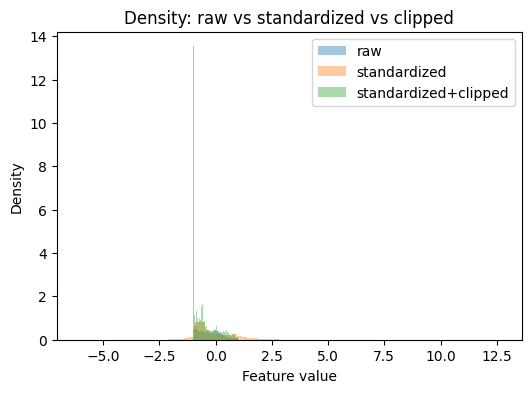

In [14]:
def to_flat_numpy(x: torch.Tensor) -> np.ndarray:
    return x.detach().cpu().numpy().reshape(-1)

raw_flat = to_flat_numpy(x_raw)
std_flat = to_flat_numpy(x_std)
clip_flat = to_flat_numpy(x_clip)

plt.figure(figsize=(6, 4))
plt.hist(raw_flat, bins=80, density=True, alpha=0.4, label="raw")
plt.hist(std_flat, bins=80, density=True, alpha=0.4, label="standardized")
plt.hist(clip_flat, bins=80, density=True, alpha=0.4, label="standardized+clipped")
plt.xlabel("Feature value")
plt.ylabel("Density")
plt.legend()
plt.title("Density: raw vs standardized vs clipped")
plt.show()


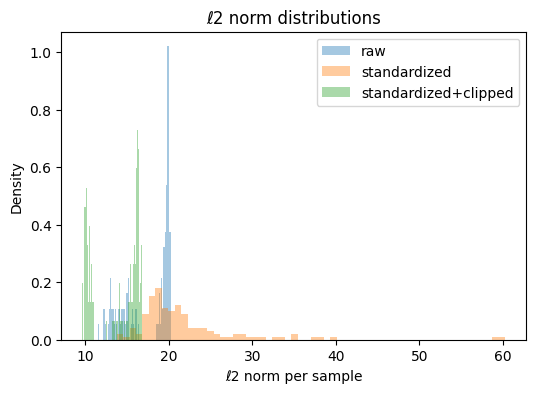

In [15]:
def sample_l2_norms(x: torch.Tensor) -> np.ndarray:
    # reshape to (B, D)
    if x.ndim == 3 and x.shape[1] == 1:
        x_flat = x[:, 0, :]
    elif x.ndim == 2:
        x_flat = x
    else:
        raise ValueError(f"Unexpected shape {x.shape}")
    norms = torch.linalg.vector_norm(x_flat, dim=1)
    return norms.detach().cpu().numpy()

raw_norms = sample_l2_norms(x_raw)
std_norms = sample_l2_norms(x_std)
clip_norms = sample_l2_norms(x_clip)

plt.figure(figsize=(6, 4))
plt.hist(raw_norms, bins=60, density=True, alpha=0.4, label="raw")
plt.hist(std_norms, bins=60, density=True, alpha=0.4, label="standardized")
plt.hist(clip_norms, bins=60, density=True, alpha=0.4, label="standardized+clipped")
plt.xlabel("ℓ2 norm per sample")
plt.ylabel("Density")
plt.legend()
plt.title("ℓ2 norm distributions")
plt.show()


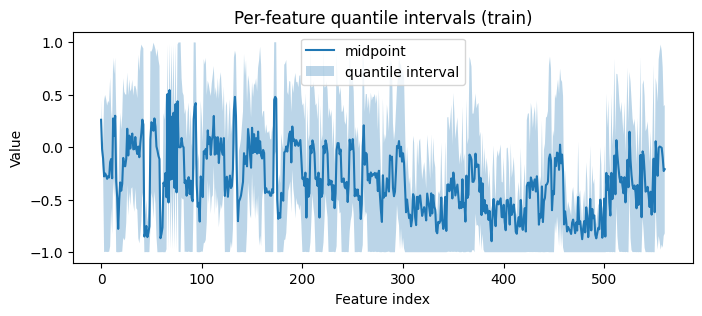

In [16]:
q_low = stats.q_low
q_high = stats.q_high
q_mid = (q_low + q_high) / 2.0
width = q_high - q_low
dims = np.arange(len(q_low))

plt.figure(figsize=(8, 3))
plt.plot(dims, q_mid, label="midpoint")
plt.fill_between(dims, q_low, q_high, alpha=0.3, label="quantile interval")
plt.xlabel("Feature index")
plt.ylabel("Value")
plt.title("Per-feature quantile intervals (train)")
plt.legend()
plt.show()


In [17]:
from typing import Tuple
from src.features import standardize
from src.clip import clip_quantile_box

def preprocess_loader_to_tensors(
    loader,
    stats: FeatureStats,
    expand_margin: float = 0.0,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xs = []
    ys = []
    for x, y in loader:
        x = standardize(x, stats)
        x = clip_quantile_box(x, stats, expand_margin=expand_margin)
        xs.append(x)
        ys.append(y)
    X = torch.cat(xs, dim=0)
    Y = torch.cat(ys, dim=0)
    return X, Y


In [18]:
# Preprocess full train and test sets
X_train_prep, y_train_prep = preprocess_loader_to_tensors(
    train_loader, stats, expand_margin=0.0
)

X_test_prep, y_test_prep = preprocess_loader_to_tensors(
    test_loader, stats, expand_margin=0.0
)

print("Preprocessed train:", X_train_prep.shape, y_train_prep.shape)
print("Preprocessed test :", X_test_prep.shape, y_test_prep.shape)

Preprocessed train: torch.Size([7352, 1, 561]) torch.Size([7352])
Preprocessed test : torch.Size([2947, 1, 561]) torch.Size([2947])


In [19]:
preprocessed_dataset = {
    "X_train": X_train_prep,
    "y_train": y_train_prep,
    "X_test": X_test_prep,
    "y_test": y_test_prep,
    "feature_stats_path": "feature_stats.npz",  # for reference
}

torch.save(preprocessed_dataset, "har_preprocessed.pt")
print("Saved to har_preprocessed.pt")

Saved to har_preprocessed.pt


In [20]:
import torch
from src.features import FeatureStats

data = torch.load("har_preprocessed.pt")
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

stats = FeatureStats.load(data["feature_stats_path"])

In [22]:
from src.train import train_classifier

stats = FeatureStats.load("feature_stats.npz")

In [23]:
def preprocess_qbox_batch(X: torch.Tensor) -> torch.Tensor:
    # clip in raw space
    X_clip = clip_quantile_box(X, stats)
    # then standardize
    X_std = standardize(X_clip, stats)
    return X_std

In [24]:
history_qbox = train_classifier(
    model_qbox,
    train_loader,
    val_loader,
    device,
    epochs=20,
    lr=1e-3,
    preprocess_fn=preprocess_qbox_batch,
)

NameError: name 'model_qbox' is not defined